# CS345 Final Project Report
## Introduction
### Dataset

The dataset used for this project is from a posting from [kaggle.com](https://kaggle.com) called [Predicting Credit Card Customer Segmentation](https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m/data) which sources an upload to [zendoo.org](https://zenodo.org) by a user named *zhyli* under the *Creative Commons Attribution 4.0 International* license. Here is the APA citation:

*zhyli. (2020). Prediction of Churning Credit Card Customers [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4322342*

This dataset contains many features that are both personal and financial, our usecase is to use personal features to make finanical classifications. Here are the personal features that are important to for our experiments, their data type and what they mean.

- `Attrition_Flag`: *boolean* - (`'Existing Customer'`/`'Attrited Customer'`) A boolean value representing if an entry is currently a customer or used to be a customer in the past.
- `Customer_Age`: *integer* - The age of the customer in years.
- `Gender`: *boolean* - (`M`/`F`) The gender of the customer.
- `Dependant_Count`: *integer* - The number of dependants that the customer has (Ex. child, partner, elderly parent).
- `Education_Level`: *categorical* - The highest education level that the customer has achieved which can include `'Uneducated'`, `'High School'`, `'College'`, `'Graduate'` or `'Unknown'`. 
- `Marital_Status`: *categorical* - The marital status of the customer which can include `'Single'`, `'Married'` or `'Unknown'` which is the reason this feature is not boolean.
- `Income_Category`: *categorical* - The range of income that the customer falls into based upon their annual income which ranges from `'Less than $40k'`, `'$40k - $60k'`, `'$60k - $80k'`, `'$80k - $120k'`, or `'Unknown'`.
- `Total_Relationship_Count`: *integer* - The number of relationships that the customer has with the credit card provider (Ex. Savings account, Checking account, Mortgage, Credit card accounts). 

Here is the financial feature that we are trying to make classifications about.

- `Credit_Limit`: *integer* - The total amount of money a customer is allowed to borrow on a credit card.

Because this features is an integer, we transform it into categorical data which is explained in the [Creating Variable Classifications](#Creating-Variable-Classifications) section of this notebook.

## Data Loading and Formatting

Before we do anything, we need to load the credit card customer data properly. The `load_credit_card_customer_data` checks to see if the data file `BankChurners.csv` has already been downloaded and if not, it downloads it from `zenodo.org`. Initially we had this function return an `X, y` but it returns a `pandas` dataframe. This is because it's easier to index a `pandas` with the columns that we want to select, this functionality is present in `select_features`. We then select personal features that we want to use as information to predict a financial feature.

In [38]:
import os
import requests
import pandas as pd
import numpy as np

def load_credit_card_customer_data(X_features, y_label):
    filename = "BankChurners.csv"
    if not os.path.exists(filename):
        url = "https://zenodo.org/records/4322342/files/BankChurners.csv?download=1"
        response = requests.get(url)
        with open(filename, "wb") as f:
            f.write(response.content)

    data = pd.read_csv(filename)
    X = data[X_features].values
    y = data[y_label].values
    return data, X, y

# dict used later on for cleaner indexing
personal_features = {
    'Attrition_Flag': 0,
    'Customer_Age': 1,
    'Gender': 2,
    'Dependent_count': 3,
    'Education_Level': 4,
    'Marital_Status': 5,
    'Income_Category': 6,
    'Total_Relationship_Count': 7
}

labels_column = 'Credit_Limit'
personal_features_headers = list(personal_features.keys())

data, X, y = load_credit_card_customer_data(personal_features_headers, labels_column)
X.shape, y.shape

((10127, 8), (10127,))

Here we can see that we have the `8` personal features and `1` label column. Also there is `10127` rows in this dataset which is pretty big. However, we can see that some of the columns contain categorical data. For example, the `'Attrition_Flag'` will contain either `'Existing Customer'` or `'Attrited Customer'` and the `Gender` column will only include `M` or `F` and so on with `'Education_Level'`, `'Marital_Status'` and `'Income_Category'`.

In [39]:
pd.DataFrame(X[:5, :], columns=personal_features)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Total_Relationship_Count
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,5
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,6
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,4
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,3
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,5


### Transforming Categorical Data to Numerical Data

Classifiers like `SVM` can only interpret numerical data and not strings like `"Existing Customer"`. So we need to |convert these categorical features to binary categorical data using `OneHotEncoder`. This will create $n$ columns for $n$ different categories in the categorical column and label the entries with either $1$ or $0$ depending on if the entry is in that category. 

In [42]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(col):
    encoder = OneHotEncoder(sparse_output=False) # sparse_output=False returns a regular numpy array which is needed for hstack
    arr = encoder.fit_transform(col.reshape(-1, 1)) # reshape for hstack
    headers = encoder.categories_[0].tolist() # get the respective categories that have been created
    return headers, arr

boolean_cols = ["Attrition_Flag", "Gender"]
integer_cols  = ["Customer_Age", "Dependent_count", "Total_Relationship_Count"]
categorical_cols = ["Education_Level", "Marital_Status", "Income_Category"]

X_numerical_parts = []
header_parts = []

for col_name in boolean_cols:
    idx = personal_features[col_name]
    col = X[:, idx]
    first_value = col[0] # The first value is going to be represented by 1
    binary_col = np.where(col == first_value, 1, 0)
    X_numerical_parts.append(binary_col.reshape(-1, 1)) # reshape for hstack
    header_parts.append(f"{first_value}=1")

for col_name in integer_cols:
    idx = personal_features[col_name]
    col = X[:, idx].reshape(-1, 1) # reshape for hstack
    X_numerical_parts.append(col)
    header_parts.append(col_name)

for col_name in categorical_cols:
    idx = personal_features[col_name]
    col = X[:, idx]
    names, arr = one_hot_encode(col)
    X_numerical_parts.append(arr)
    header_parts.extend(names)

X_numerical = np.hstack(X_numerical_parts)

pd.DataFrame(X_numerical[:5, :], columns=header_parts)

,Existing Customer=1,M=1,Customer_Age,Dependent_count,Total_Relationship_Count,College,Doctorate,Graduate,High School,Post-Graduate,...,Divorced,Married,Single,Unknown,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Unknown
0,1,1,45,3,5,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,49,5,6,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,51,3,4,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,0,40,4,3,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,40,3,5,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now we have completely numerical data, we can see that each category has its own binary column. We also have increased the number of columns from `8` to `22` because each category gets its own column.

In [25]:
X_numerical.shape

(10127, 22)

## Creating Variable Classifications

The last data formatting step we need to perform is the categorizaion of the `'Credit_Limit'`. For a binary classification, we will classify a customer based on if their credit limit is higher than the median or lower than the median. Later on, we will create more categories in order to compare the accuracy of a model based upon the number of different classifications it can make. We can take variable $g$ which represents the number of different classifications. When $g = 2$ we are classifying if a customer has a credit limit higher than the median, or a credit limit lower than the median. When $g = 3$ we are classifying if a customer is in the bottom 33rd percentile, in the middle 33rd percentile, or in the top 33rd percentile in terms of credit limit. This is part of our experimentation as this is an idea we had in order to measure the accuracy of models based the number of classification they could make.

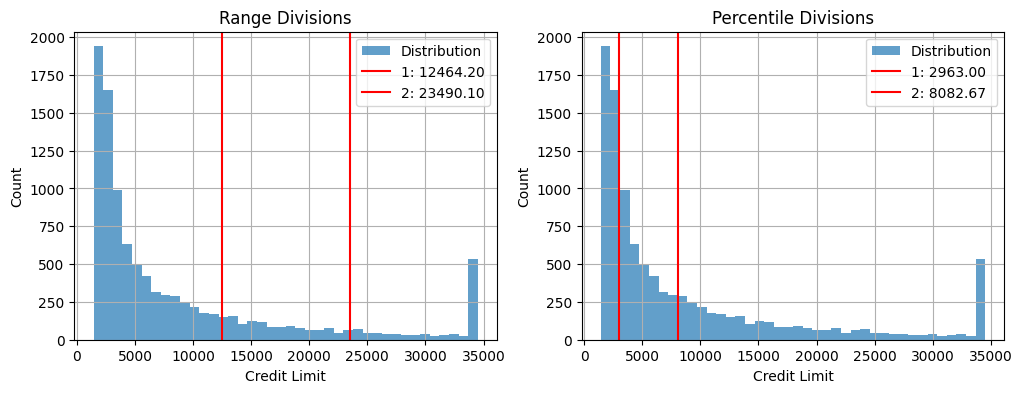

In [46]:
import matplotlib.pyplot as plt

def plot_divisions(ax, y, divisions, title=""):
    ax.hist(y, bins=40, alpha=0.7, label="Distribution")

    for i, division in enumerate(divisions):
        ax.axvline(division, color='red', label=f"{i+1}: {division:.2f}")

    ax.set_title(title)
    ax.set_xlabel("Credit Limit")
    ax.set_ylabel("Count")
    ax.grid(True)
    ax.legend()

def make_division(y, divisions):
    y = np.array(y)
    divisions = np.array(divisions)
    labels = np.zeros(len(y), dtype=int)
    
    for i, d in enumerate(divisions):
        labels[y > d] = i + 1
    return labels

def divide_percentile(g, y):
    chunk_size = 100 / g
    divisions = []
    for i in range(1, g): # start at 1 because we don't want to divide at the 0th percentile
        percentile = np.percentile(y, chunk_size * i)
        divisions.append(percentile)
    return divisions

def divide_range(g, y):
    y_min = min(y)
    y_max = max(y)
    step = (y_max - y_min) / g

    divisions = []
    for i in range(1, g):
        divisions.append(y_min + i * step)

    return divisions

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
divisions_range = divide_range(3, y)
plot_divisions(axes[0], y, divisions_range, title="Range Divisions")

divisions_percentile = divide_percentile(3, y)
plot_divisions(axes[1], y, divisions_percentile, title="Percentile Divisions")
plt.show()

To interpret the graph above, one third of the total amount of entries fall below the first division ($\lt 2963.00$) another third fall between the two divisions ($\ge 2963.00$ and $\lt 8082.67$) and the last third fall above the second division ($\ge 8082.67$). In other words, we are dividing the entries into exact thirds so each classification has an equal number of entries, in the case where $g = 3$ each division contains $33.33 \%$ of the entries. 

Here you can see that we are creating classifications based on dividing the credit limit range into equal thirds. The question we are going to ask later on is, "*Does some model perform better on data labeled with an equal **amount of entries** in each classification, or does it perform better on data labeled with an equal **range of labels**?*" (`divide_percentile` or `divide_range`).

Next, we can just divide the entries equally based upon the credit limit itself. Here with *range division* we are dividing the data based upon the range of the credit limit. This will create a variable number of classifications just as `divide_percentile` does. 

For now we are going to use the binary classification using `divide_percentile(2, y)` in order to classify entries if they are higher or lower than the median, but later on we will discuss the performance of models based upon which method we are using to label the data.

In [47]:
y_median = np.median(y)
print(f"y median: {y_median}")

# binary classification, half above the median, half below the median
divisions = divide_percentile(2, y)
y_median = make_division(y, divisions) 

pd.DataFrame([y[:5], y_median[:5]], index=["y", "y_median"])

y median: 4549.0


,0,1,2,3,4
y,12691.0,8256.0,3418.0,3313.0,4716.0
y_median,1.0,1.0,0.0,0.0,1.0


## K-Nearest Neighbors Classifier vs Radius Neighbors Classifier

The [K-Nearest Neighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) classifies entries based upon the set of $k$ nearest neighbors to the  

The [Radius Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html) (which was not covered in class)

Our process for comparing the two classifiers goes as follows:
1. Test and cross validate the accuracy of KNN with different values of $k$ on the unstandardized data.
2. Standardize the data then test and cross validate accuracy of KNN with different values of $k$ again.
3. Discuss the differences in results between the standardized and unstandardized data.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_numerical, y_median, test_size=0.3, random_state=42)

classifier = KNeighborsClassifier(1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

np.float64(0.6304705495228694)